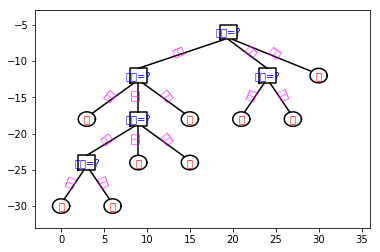

In [2]:
#!/usr/bin/env python
# -*- coding: UTF-8 -*-
# Created by YWJ on 2018/1/14

from dtreeplot_ID3 import dtreeplot_ID3 as dtreeplot
import math

#属性类
class property:
    def __init__(self,idnum,attribute):
        self.is_continuity=False     #连续型属性标记
        self.attribute=attribute     #属性标签
        self.subattributes=[]     #属性子标签
        self.id=idnum     #属性排在输入文本的第几位
        self.index={}     #属性子标签的索引值

#决策树生成类
class dtree():
    '''
    构造函数
    filename:输入文件名
    haveID:输入是否带序号
    property_set：为空则计算全部属性，否则记录set中的属性
    '''
    def __init__(self,filename,haveID,property_set):

        self.data=[]
        self.data_property=[]
        #读入数据
        self.__dataread(filename,haveID)
        #判断选择的属性集合
        if len(property_set)>0:
            tmp_data_property=[]
            for i in property_set:
                tmp_data_property.append(self.data_property[i])
            tmp_data_property.append(self.data_property[-1])
        else:
            tmp_data_property=self.data_property

        #决策树树形数组结构
        self.treelink=[]

        #决策树主递归
        self.__TreeGenerate(range(0,len(self.data[-1])),tmp_data_property,0,[],[])

        #决策树绘制
        dtreeplot(self.treelink,6,1,-6)

    '''
        决策树主递归
        data_set:当前样本集合
        property_set：当前熟悉集合
        father:父节点索引值
        attribute:父节点连接当前节点的子属性值
        threshold:如果是连续参数就是阈值，否则为空
    '''
    def __TreeGenerate(self, data_set, property_set, father, attribute, threshold):
        # 新增一个节点
        self.treelink.append([])
        # 新节点的位置
        curnode = len(self.treelink) - 1
        # 记录新节点的父亲节点
        self.treelink[curnode].append(father)

        # 结束条件1：所有样本同一分类
        current_data_class = self.__count(data_set, property_set[-1])
        if (len(current_data_class) == 1):
            self.treelink[curnode].append(self.data[-1][data_set[0]])
            self.treelink[curnode].append(attribute)
            self.treelink[curnode].append(threshold)
            return

        # 结束条件2：所有样本相同属性，选择分类数多的一类作为分类
        if all(len(self.__count(data_set, property_set[i])) == 1 for i in range(0, len(property_set) - 1)):
            max_count = -1;
            for dataclass in property_set[-1].subattributes:
                if current_data_class[dataclass] > max_count:
                    max_attribute = dataclass
                    max_count = current_data_class[dataclass]
            self.treelink[curnode].append(max_attribute)
            self.treelink[curnode].append(attribute)
            self.treelink[curnode].append(threshold)
            return

        # 信息增益选择最优属性与阈值
        prop, threshold = self.__entropy_paraselect(data_set, property_set)

        # 记录当前节点的最优属性标签与父节点连接当前节点的子属性值
        self.treelink[curnode].append(prop.attribute)
        self.treelink[curnode].append(attribute)

        # 从属性集合中移除当前属性
        property_set.remove(prop)

        # 判断是否是连续属性
        if (prop.is_continuity):
            # 连续属性分为2子属性，大于和小于
            tmp_data_set = [[], []]
            for i in data_set:
                tmp_data_set[self.data[prop.id][i] > threshold].append(i)
            for i in [0, 1]:
                self.__TreeGenerate(tmp_data_set[i], property_set[:], curnode, prop.subattributes[i], threshold)
        else:
            # 离散属性有多子属性
            tmp_data_set = [[] for i in range(0, len(prop.subattributes))]
            for i in data_set:
                tmp_data_set[prop.index[self.data[prop.id][i]]].append(i)

            for i in range(0, len(prop.subattributes)):
                if len(tmp_data_set[i]) > 0:
                    self.__TreeGenerate(tmp_data_set[i], property_set[:], curnode, prop.subattributes[i], [])
                else:
                    # 如果某一个子属性不存没有对应的样本，则选择父节点分类更多的一项作为分类
                    self.treelink.append([])
                    max_count = -1;
                    tnode = len(self.treelink) - 1
                    for dataclass in property_set[-1].subattributes:
                        if current_data_class[dataclass] > max_count:
                            max_attribute = dataclass
                            max_count = current_data_class[dataclass]
                    self.treelink[tnode].append(curnode)
                    self.treelink[tnode].append(max_attribute)
                    self.treelink[tnode].append(prop.subattributes[i])
                    self.treelink[tnode].append(threshold)

        # 为没有4个值得节点用空列表补齐4个值
        for i in range(len(self.treelink[curnode]), 4):
            self.treelink[curnode].append([])

    '''
        信息增益算则最佳属性
        data_set:当前样本集合
        property_set:当前属性集合
    '''
    def __entropy_paraselect(self, data_set, property_set):
        # 分离散和连续型分别计算信息增益，选择最大的一个
        max_ent = -10000
        for i in range(0, len(property_set) - 1):
            prop_id = property_set[i].id
            if (property_set[i].is_continuity):
                tmax_ent = -10000
                xlist = self.data[prop_id][:]
                xlist.sort()
                # 连续型求出相邻大小值的平局值作为待选的最佳阈值
                for j in range(0, len(xlist) - 1):
                    xlist[j] = (xlist[j + 1] + xlist[j]) / 2
                for j in range(0, len(xlist) - 1):
                    if (i > 0 and xlist[j] == xlist[j - 1]):
                        continue
                    cur_ent = 0
                    nums = [[0, 0], [0, 0]]
                    for k in data_set:
                        nums[self.data[prop_id][k] > xlist[j]][property_set[-1].index[self.data[-1][k]]] += 1
                    for k in [0, 1]:
                        subattribute_sum = nums[k][0] + nums[k][1]
                        if (subattribute_sum > 0):
                            p = nums[k][0] / subattribute_sum
                            cur_ent += (p * math.log(p + 0.00001, 2) + (1 - p) * math.log(1 - p + 0.00001,
                                                                                          2)) * subattribute_sum / len(
                                data_set)
                    if (cur_ent > tmax_ent):
                        tmax_ent = cur_ent
                        tmp_threshold = xlist[j]
                if (tmax_ent > max_ent):
                    max_ent = tmax_ent;
                    bestprop = property_set[i];
                    best_threshold = tmp_threshold;
            else:
                # 直接统计并计算
                cur_ent = 0
                nums = [[0, 0] for i in range(0, len(property_set[i].subattributes))]
                for j in data_set:
                    nums[property_set[i].index[self.data[prop_id][j]]][property_set[-1].index[self.data[-1][j]]] += 1
                for j in range(0, len(property_set[i].subattributes)):
                    subattribute_sum = nums[j][0] + nums[j][1]
                    if (subattribute_sum > 0):
                        p = nums[j][0] / subattribute_sum
                        cur_ent += (p * math.log(p + 0.00001, 2) + (1 - p) * math.log(1 - p + 0.00001,
                                                                                      2)) * subattribute_sum / len(
                            data_set)
                if (cur_ent > max_ent):
                    max_ent = cur_ent;
                    bestprop = property_set[i];
                    best_threshold = [];

        return bestprop, best_threshold

    '''
        计算当前样本在某个属性下的分类情况
        '''
    def __count(self, data_set, prop):
        out = {}

        rowdata = self.data[prop.id]
        for i in data_set:
            if rowdata[i] in out:
                out[rowdata[i]] += 1
            else:
                out[rowdata[i]] = 1;

        return out

    '''
        输入数据处理
    '''
    def __dataread(self, filename, haveID):
        file = open(filename, 'r')
        linelen = 0
        first = 1
        while 1:
            # 按行读
            line = file.readline()

            if not line:
                break

            line = line.strip('\n')
            rowdata = line.split(',')
            # 如果有编号就去掉第一列
            if haveID:
                del rowdata[0]

            if (linelen == 0):
                # 处理第一行，初始化属性类对象，记录属性的标签
                for i in range(0, len(rowdata)):
                    self.data.append([])
                    self.data_property.append(property(i, rowdata[i]))
                    self.data_property[i].attribute = rowdata[i]
                linelen = len(rowdata)
            elif (linelen == len(rowdata)):
                if (first == 1):
                    # 处理第二行，记录属性是否是连续型和子属性
                    for i in range(0, len(rowdata)):
                        if (isnumeric(rowdata[i])):
                            self.data_property[i].is_continuity = True
                            self.data[i].append(float(rowdata[i]))
                            self.data_property[i].subattributes.append("小于")
                            self.data_property[i].index["小于"] = 0
                            self.data_property[i].subattributes.append("大于")
                            self.data_property[i].index["大于"] = 1
                        else:
                            self.data[i].append(rowdata[i])
                else:
                    # 处理后面行，记录子属性
                    for i in range(0, len(rowdata)):
                        if (self.data_property[i].is_continuity):
                            self.data[i].append(float(rowdata[i]))
                        else:
                            self.data[i].append(rowdata[i])
                            if rowdata[i] not in self.data_property[i].subattributes:
                                self.data_property[i].subattributes.append(rowdata[i])
                                self.data_property[i].index[rowdata[i]] = len(self.data_property[i].subattributes) - 1
                first = 0
            else:
                continue

'''
判断是否是数字
'''
def isnumeric(s):
    return all(c in "0123456789.-" for c in s)

filename = "../data/watermelon_3.data"
property_set = range(0, 6)
link = dtree(filename, True, property_set)